In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

ModuleNotFoundError: No module named 'torch'

In [6]:
pip list | grep torch

Note: you may need to restart the kernel to use updated packages.


'grep' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

In [ ]:
img, label = dataset[0]
print('Label: ', label)
print(img[:,10:15,10:15])

Label:  5
tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])


Label:  5


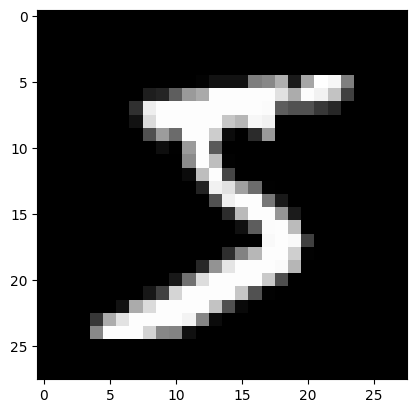

In [ ]:
plt.imshow(img.permute(1,2,0), cmap='gray')
print('Label: ', label)

In [ ]:
img.shape

torch.Size([1, 28, 28])

In [ ]:
batch_size = 64
sample_size = 100

In [ ]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
def show_batch():
    for images, _ in dataloader:
        grid = make_grid(images, nrow=8)
        plt.imshow(grid.permute(1,2,0), cmap='gray')
        break

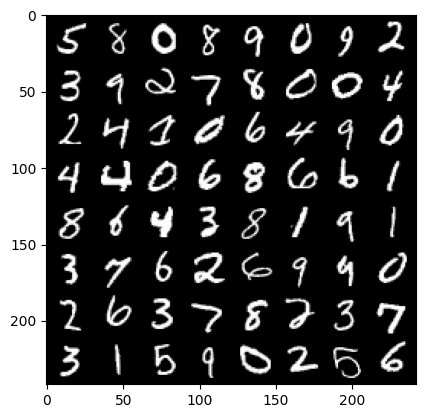

In [ ]:
show_batch()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
class Label(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(10, 784),
            nn.BatchNorm1d(784),
            nn.LeakyReLU(0.01)
        )

    def forward(self, labels):
        x = F.one_hot(labels, num_classes=10)
        x = x.float()

        return self.fc(x)

In [ ]:
class Generator(nn.Module):
    def __init__(self, sample_size):
        super().__init__()

        self.sample_size = sample_size

        self.fc = nn.Sequential(
            nn.Linear(sample_size, 784),
            nn.BatchNorm1d(784),
            nn.LeakyReLU(0.01)
            # sample_size => 784
        )

        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01)
            # 16 x 7 x 7 => 32 x 14 x 14
        )

        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
            # 32 x 14 x 14 => 1 x 28 x 28
        )

        self.Label = Label()
        self.Label.to(device)

    def forward(self, labels):
        batch_size = len(labels)

        lab = self.Label(labels)

        image = torch.randn(batch_size, self.sample_size).to(device)

        x = self.fc(image)
        x = x + lab
        x = x.reshape(-1, 16,7,7)

        x = self.conv1(x)
        x = self.conv2(x)

        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.01),
            # 1 x 28 x 28 => 32 x 14 x 14

            nn.Conv2d(32, 16, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.01)
            # 32 x 14 x 14 => 16 x 7 x 7
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 784),
            nn.BatchNorm1d(784),
            nn.LeakyReLU(0.01),

            nn.Linear(784, 1),
            nn.Sigmoid()
        )

        self.Label = Label()
        self.Label.to(device)

    def forward(self, images, labels):
        batch_size = len(labels)

        labs = self.Label(labels)
        labs = torch.reshape(labs, (batch_size, 16, 7, 7))  # 784 -> 16 * 7 * 7

        x = self.conv(images)
        x = x + labs

        pred = self.fc(x)

        return pred

In [ ]:
generator = Generator(sample_size)
discriminator = Discriminator()

In [ ]:
generator.to(device)
discriminator.to(device)

In [ ]:
opt_g = torch.optim.Adam(generator.parameters(), lr=1.0e-4)
opt_d = torch.optim.Adam(discriminator.parameters(), lr=1.0e-4)

In [ ]:
criterion_d = nn.BCELoss()

In [ ]:
def training_discriminator(images, labels):
    real_targets = torch.ones(len(labels), 1).to(device)
    fake_targets = torch.zeros(len(labels), 1).to(device)


    pred_real = discriminator(images, labels)
    loss_real = criterion_d(pred_real, real_targets)

    gen_images = generator(labels)
    pred_fake = discriminator(gen_images, labels)
    loss_fake = criterion_d(pred_fake, fake_targets)

    d_loss = (loss_real + loss_fake) / 2

    opt_d.zero_grad()
    d_loss.backward()
    opt_d.step()

    return d_loss.item()

In [ ]:
def training_generator(labels):
    real_targets = torch.ones(len(labels), 1).to(device)
    fake_targets = torch.zeros(len(labels), 1).to(device)

    gen_images = generator(labels)
    pred = discriminator(gen_images, labels)
    loss_g = criterion_d(pred, real_targets)

    opt_g.zero_grad()
    loss_g.backward()
    opt_g.step()

    return loss_g.item()

In [ ]:
sample_dir = 'generated_images'
if os.path.exists(sample_dir) == False:
    os.mkdir(sample_dir)

In [ ]:
def save_image_grid(epoch, images, ncol):
    image_grid = make_grid(images, ncol)     # Into a grid
    image_grid = image_grid.permute(1, 2, 0) # Channel to last
    image_grid = image_grid.cpu().numpy()    # Into Numpy

    plt.imshow(image_grid)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f'./generated_images/generated_{epoch:03d}.jpg')
    plt.close()

In [ ]:
for epoch in range(100):
    g_losses = []
    d_losses = []

    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        loss_d = training_discriminator(images, labels)
        loss_g = training_generator(labels)

        g_losses.append(loss_g)
        d_losses.append(loss_d)

    print(f"Epoch: {epoch + 1}, Disc_loss: {np.mean(d_losses)}, Gen_loss: {np.mean(g_losses)}")

    labels = torch.LongTensor(list(range(10))).repeat(8).flatten().to(device)
    save_image_grid(epoch, generator(labels), ncol=10)

Text(0.5, 1.0, 'Losses')

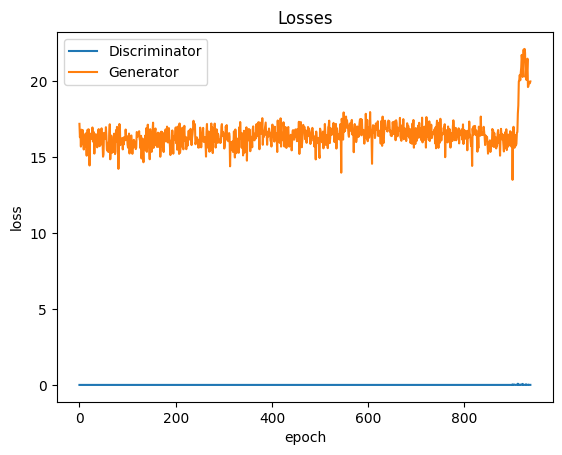

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

In [ ]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
torch.save(generator.Label.state_dict(), 'Label_G.pth')
torch.save(discriminator.Label.state_dict(), 'Label_D.pth')

In [ ]:
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

In [ ]:
import imageio

images = []
for e in range(100):
    img_name = files[e]
    images.append(imageio.imread(img_name))
imageio.mimsave('generation_animation_3July.gif', images, fps=5)